# Построение моделей предсказания надоя и качества молока коров

Нужно создать модели линейной и логичтической регрессии для покупки лучших коров на ферму.

## Цель
С помощью моделей нужно отобрать коров по двум критериям:
 - средний удой за год — не менее 6000 килограммов;
 - молоко должно быть вкусным.

## Описание данных:
### Текущее стадо
- `id` — уникальный идентификатор коровы.
- `Удой, кг` — масса молока, которую корова даёт в год (в килограммах).
- `ЭКЕ (Энергетическая кормовая единица)` — показатель питательности корма коровы.
- `Сырой протеин, г` — содержание сырого протеина в корме (в граммах).
- `СПО (Сахаро-протеиновое соотношение)` — отношение сахара к протеину в корме коровы.
- `Порода` — порода коровы.
- `Тип пастбища` — ландшафт лугов, на которых паслась корова.
- `порода папы_быка` — порода папы коровы.
- `Жирность,%` — содержание жиров в молоке (в процентах).
- `Белок,%` — содержание белков в молоке (в процентах).
- `Вкус молока` — оценка вкуса по личным критериям фермера, бинарный признак (вкусно, не вкусно).
- `Возраст` — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).
### Родитель коров
- `id` — уникальный идентификатор коровы.
- `Имя Папы` — имя папы коровы.
### Продаваемые коровы
- `Порода` — порода коровы.
- `Тип пастбища` — ландшафт лугов, на которых паслась корова.
- `порода папы_быка` — порода папы коровы.
- `Имя_папы` — имя папы коровы.
- `Текущая_жирность,%` — содержание жиров в молоке (в процентах).
- `Текущий_уровень_белок,%` — содержание белков в молоке (в процентах).
- `Возраст` — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).

## План исследования

1) Предобработка данных
2) Исследовательский анализ данных
3) Подготовка данных к ML
4) Обучение экспериментальных моделей линейной регрессии
5) Оценка метрик
6) Промежуточные выводы
7) Подготовка данных для логистической регрессии
8) Обучение экспериментальных моделей логистической регрессии
9) Оценка метрик
10) Промежуточные выводы
10) Общие выводы

##  Предобработка данных

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime as dt
import math
from scipy import stats as st

In [2]:
try:
    own_herd = pd.read_csv(r".\source\ferma_main.csv", sep=';')
    cows_ancestor = pd.read_csv(r".\source\ferma_dad.csv", sep=';')
    sale_herd = pd.read_csv(r".\source\cow_buy.csv", sep=';')
except:
    own_herd = pd.read_csv("/datasets/ferma_main.csv", sep=';')
    cows_ancestor = pd.read_csv("/datasets/ferma_dad.csv", sep=';')
    sale_herd = pd.read_csv("/datasets/cow_buy.csv", sep=';')

pd.set_option('display.max_columns', None)
print(f"Own heard:\n{own_herd.head(20)}")
print(f"Cows ancestors:\n{cows_ancestor.head(20)}")
print(f"Herd for sale:\n{sale_herd.head(20)}")

Own heard:
    id  Удой, кг ЭКЕ (Энергетическая кормовая единица)  Сырой протеин, г  \
0    1      5863                                  14,2              1743   
1    2      5529                                  12,8              2138   
2    3      5810                                    14              1854   
3    4      5895                                  12,4              2012   
4    5      5302                                  12,8              1675   
5    6      5254                                  12,7              1806   
6    7      5910                                  13,2              1792   
7    8      6179                                  14,7              1806   
8    9      6783                                  14,2              1918   
9   10      5339                                  13,4              1791   
10  11      5591                                  13,7              1678   
11  12      6563                                  16,5              2328   
1

Переименуем называния колонок на англоязычные, в соостветствии с конвенциональным именованием.

In [3]:
own_herd = own_herd.rename(columns={"Удой, кг": "yield",
                                    "ЭКЕ (Энергетическая кормовая единица)": "EFU",
                                    "Сырой протеин, г": "raw_protein",
                                    "СПО (Сахаро-протеиновое соотношение)": "SPR",
                                    "Порода": "breed",
                                    "Тип пастбища": "pasture_type",
                                    "порода папы_быка": "ancestor_breed",
                                    "Жирность,%": "fatness",
                                    "Белок,%": "proteins",
                                    "Вкус молока": "is_milk_tasty",
                                    "Возраст": "is_old",})
cows_ancestor = cows_ancestor.rename(columns={"Удой, кг": "yield",
                                    "Имя Папы": "ancestor_name"})
sale_herd = sale_herd.rename(columns={"Порода": "breed",
                                    "Тип пастбища": "pasture_type",
                                    "порода папы_быка": "ancestor_breed",
                                    "Имя_папы": "ancestor_name",
                                    "Текущая_жирность,%": "fatness",
                                    "Текущий_уровень_белок,%": "proteins",
                                    "Возраст": "is_old"})

In [4]:
own_herd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              634 non-null    int64 
 1   yield           634 non-null    int64 
 2   EFU             634 non-null    object
 3   raw_protein     634 non-null    int64 
 4   SPR             634 non-null    object
 5   breed           634 non-null    object
 6   pasture_type    634 non-null    object
 7   ancestor_breed  634 non-null    object
 8   fatness         634 non-null    object
 9   proteins        634 non-null    object
 10  is_milk_tasty   634 non-null    object
 11  is_old          634 non-null    object
dtypes: int64(3), object(9)
memory usage: 59.6+ KB


In [5]:
cows_ancestor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             629 non-null    int64 
 1   ancestor_name  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


In [6]:
sale_herd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   breed           20 non-null     object
 1   pasture_type    20 non-null     object
 2   ancestor_breed  20 non-null     object
 3   ancestor_name   20 non-null     object
 4   fatness         20 non-null     object
 5   proteins        20 non-null     object
 6   is_old          20 non-null     object
dtypes: object(7)
memory usage: 1.2+ KB


Проверим наличие явных дубликатов.

In [7]:
def handle_duplicates(dataframe):
    duplicates_count = dataframe.duplicated().sum()

    if duplicates_count > 0:
        dataframe.drop_duplicates(inplace=True)
    
    print(f"Droped {duplicates_count} duplicates.")

In [8]:
handle_duplicates(own_herd)
handle_duplicates(cows_ancestor)
handle_duplicates(sale_herd)

Droped 5 duplicates.
Droped 0 duplicates.
Droped 4 duplicates.


Преобразуем данные к соответствующим типам.

In [9]:
def replace_fp_delimiter(columns, df):
    for col in columns:
        df[col] = df[col].str.replace(",", ".")

In [10]:
own_herd.nunique()

id                629
yield             528
EFU                55
raw_protein       401
SPR                12
breed               2
pasture_type        3
ancestor_breed      3
fatness            50
proteins           15
is_milk_tasty       2
is_old              2
dtype: int64

In [11]:
float_columns = ["EFU", "SPR", "fatness","proteins"]
replace_fp_delimiter(float_columns, own_herd)
own_herd = own_herd.astype({"EFU": "float",
                            "SPR": "float",
                            "breed": "category",
                            "pasture_type": "category",
                            "ancestor_breed": "category",
                            "fatness": "float",
                            "proteins": "float",
                            "is_milk_tasty": "category",
                            "is_old": "category"})

own_herd["is_milk_tasty"] = pd.Series([cow_milk == "вкусно" for cow_milk in own_herd["is_milk_tasty"]], dtype="category")
own_herd["is_old"] = pd.Series([cow_milk == "более_2_лет" for cow_milk in own_herd["is_old"]], dtype="category")

In [12]:
own_herd.head(1)

,id,yield,EFU,raw_protein,SPR,breed,pasture_type,ancestor_breed,fatness,proteins,is_milk_tasty,is_old
0,1,5863,14.2,1743,0.89,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,True,True


In [13]:
own_herd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 0 to 628
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   id              629 non-null    int64   
 1   yield           629 non-null    int64   
 2   EFU             629 non-null    float64 
 3   raw_protein     629 non-null    int64   
 4   SPR             629 non-null    float64 
 5   breed           629 non-null    category
 6   pasture_type    629 non-null    category
 7   ancestor_breed  629 non-null    category
 8   fatness         629 non-null    float64 
 9   proteins        629 non-null    float64 
 10  is_milk_tasty   629 non-null    category
 11  is_old          629 non-null    category
dtypes: category(5), float64(4), int64(3)
memory usage: 43.0 KB


In [14]:
cows_ancestor.nunique()

id               629
ancestor_name      4
dtype: int64

In [15]:
cows_ancestor = cows_ancestor.astype({"ancestor_name": "category"})

In [16]:
cows_ancestor.head(1)

,id,ancestor_name
0,1,Буйный


In [17]:
cows_ancestor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   id             629 non-null    int64   
 1   ancestor_name  629 non-null    category
dtypes: category(1), int64(1)
memory usage: 5.9 KB


In [18]:
sale_herd.nunique()

breed              2
pasture_type       2
ancestor_breed     2
ancestor_name      4
fatness           12
proteins          12
is_old             2
dtype: int64

In [19]:
float_columns = ["fatness","proteins"]
replace_fp_delimiter(float_columns, sale_herd)
sale_herd = sale_herd.astype({"breed": "category",
                            "pasture_type": "category",
                            "ancestor_breed": "category",
                            "ancestor_name": "category",
                            "fatness": "float",
                            "proteins": "float",
                            "is_old": "category"})

sale_herd["is_old"] = pd.Series([cow_milk == "более_2_лет" for cow_milk in sale_herd["is_old"]], dtype="category")

In [20]:
sale_herd.head(1)

,breed,pasture_type,ancestor_breed,ancestor_name,fatness,proteins,is_old
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,True


In [21]:
sale_herd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 0 to 18
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   breed           16 non-null     category
 1   pasture_type    16 non-null     category
 2   ancestor_breed  16 non-null     category
 3   ancestor_name   16 non-null     category
 4   fatness         16 non-null     float64 
 5   proteins        16 non-null     float64 
 6   is_old          13 non-null     category
dtypes: category(5), float64(2)
memory usage: 1.1 KB


Проверим наличие пропусков в данных.

In [22]:
own_herd.isna().sum()

id                0
yield             0
EFU               0
raw_protein       0
SPR               0
breed             0
pasture_type      0
ancestor_breed    0
fatness           0
proteins          0
is_milk_tasty     0
is_old            0
dtype: int64

In [23]:
cows_ancestor.isna().sum()

id               0
ancestor_name    0
dtype: int64

In [24]:
sale_herd.isna().sum()

breed             0
pasture_type      0
ancestor_breed    0
ancestor_name     0
fatness           0
proteins          0
is_old            3
dtype: int64

## Исследовательский анализ данных

Рассмотрим описательную статистику данных.

In [25]:
own_herd.describe()

,id,yield,EFU,raw_protein,SPR,fatness,proteins
count,629.00000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000
mean,315.00000,6188.750397,14.543879,1923.364070,0.913116,3.603657,3.075671
std,181.72094,1644.795489,1.306408,182.956251,0.032203,0.168656,0.002549
min,1.00000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,158.00000,5751.000000,13.500000,1771.000000,0.890000,3.590000,3.074000
50%,315.00000,6133.000000,14.700000,1888.000000,0.930000,3.650000,3.076000
75%,472.00000,6501.000000,15.600000,2062.000000,0.940000,3.720000,3.077000
max,629.00000,45616.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


Максимальный надой нереалистично большой. Вероятно, в данных есть выбросы.

In [27]:
sale_herd.describe()

,fatness,proteins
count,16.000000,16.000000
mean,3.571875,3.068250
std,0.141620,0.011264
min,3.340000,3.046000
25%,3.415000,3.059500
50%,3.585000,3.073500
75%,3.692500,3.076750
max,3.770000,3.081000


Для продаваемых коров количественные данные выглядят адекватно.

Далее рассмотрим в деталях каждый из признаков. Начнём с надоя.

<AxesSubplot:>

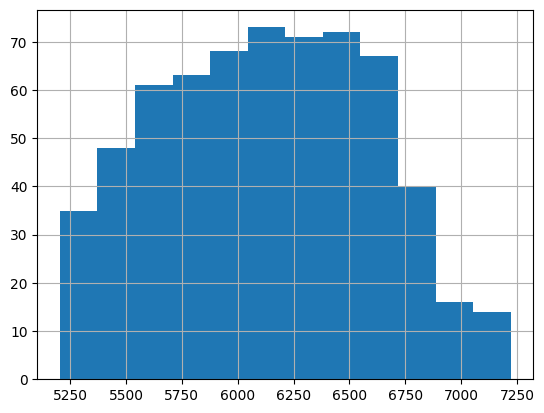

In [ ]:
own_herd["yield"].hist(bins=50)

Удалим нереалистично большой выброс и построим график частот заново.

<AxesSubplot:>

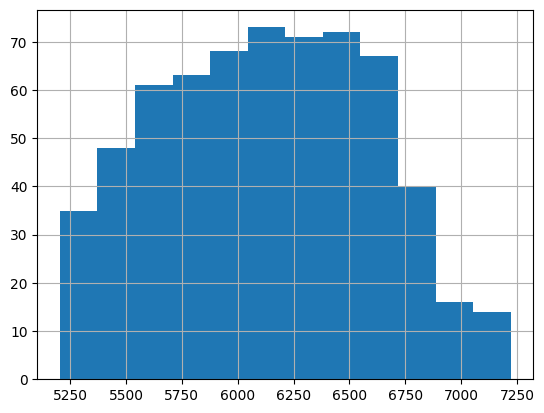

In [35]:
own_herd = own_herd[own_herd["yield"] < 15000]
own_herd["yield"].hist(bins=50)

Надоё распределён унимодально. Коров, имеющих большие надои меньше. В целом, достаточно редко встречаются коровы с надоем больше 6900 кг в год.

In [32]:
own_herd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 628 entries, 0 to 628
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   id              628 non-null    int64   
 1   yield           628 non-null    int64   
 2   EFU             628 non-null    float64 
 3   raw_protein     628 non-null    int64   
 4   SPR             628 non-null    float64 
 5   breed           628 non-null    category
 6   pasture_type    628 non-null    category
 7   ancestor_breed  628 non-null    category
 8   fatness         628 non-null    float64 
 9   proteins        628 non-null    float64 
 10  is_milk_tasty   628 non-null    category
 11  is_old          628 non-null    category
dtypes: category(5), float64(4), int64(3)
memory usage: 42.9 KB


<AxesSubplot:>

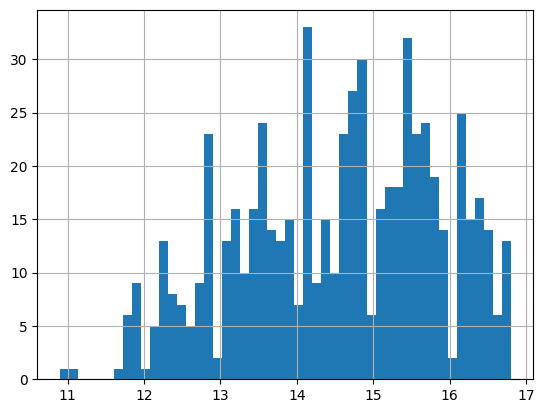

In [37]:
own_herd["EFU"].hist(bins=50)

На графике видно, что нескольким коровам попался корм с очень низкой энергетической ценностью. Стоит запомнить эту особенность и в дальнейшем решить, что с этим делать.

<AxesSubplot:>

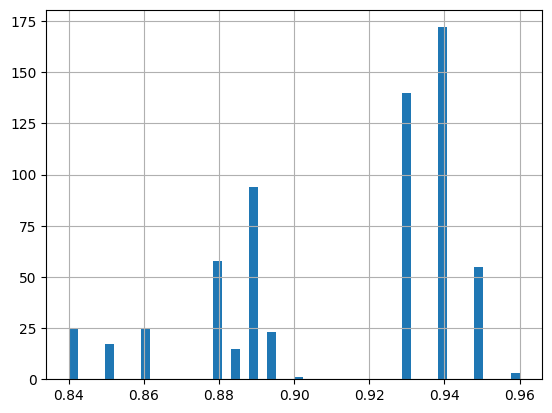

In [38]:
own_herd["SPR"].hist(bins=50)

Можно выделить три группы коров по сахаро-протеиновое соотношению в их корме: менее 0.87, от 0.87 до 0.91 и более 0.91. Рассмотрим как отличаются удой и вкус молока у коров из этих групп.

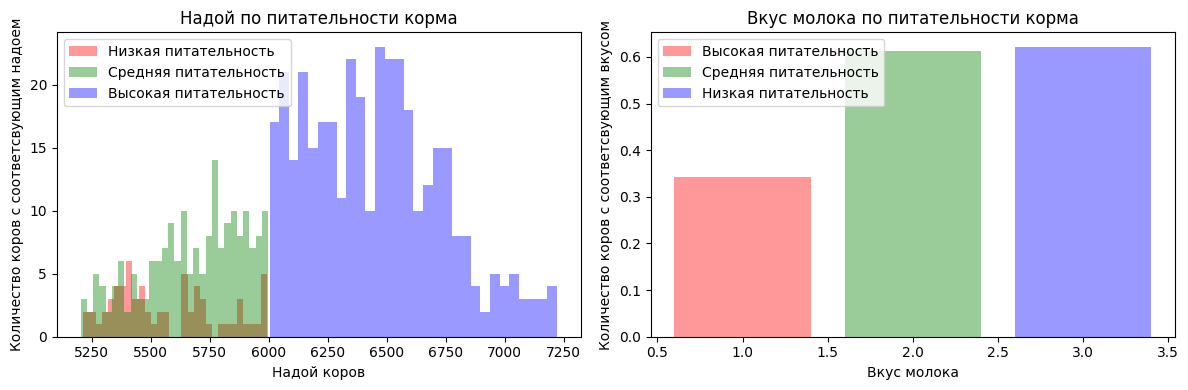

In [88]:
low_SPR = own_herd[own_herd["SPR"] < 0.87]
mid_SPR = own_herd[(own_herd["SPR"] >= 0.87) & (own_herd["SPR"] < 0.91)]
high_SPR = own_herd[own_herd["SPR"] >= 0.91]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
line11 = ax1.hist(low_SPR["yield"], bins=30, alpha = 0.4, color= 'r')
line12 = ax1.hist(mid_SPR["yield"], bins=30, alpha = 0.4, color= 'g')
line13 = ax1.hist(high_SPR["yield"], bins=30, alpha = 0.4, color= 'b')
ax1.set_title('Надой по питательности корма')
ax1.set_xlabel("Надой коров")
ax1.set_ylabel("Количество коров с соответсвующим надоем")
ax1.legend(['Низкая питательность', 'Средняя питательность', 'Высокая питательность'])

line21 = ax2.bar(1, low_SPR[low_SPR["is_milk_tasty"]].shape[0] / low_SPR.shape[0], color= 'r', alpha = 0.4)
line22 = ax2.bar(2, mid_SPR[mid_SPR["is_milk_tasty"]].shape[0] / mid_SPR.shape[0], color= 'g', alpha = 0.4)
line23 = ax2.bar(3, high_SPR[high_SPR["is_milk_tasty"]].shape[0] / high_SPR.shape[0], color= 'b', alpha = 0.4)
ax2.set_title('Вкус молока по питательности корма')
ax2.set_xlabel("Вкус молока")
ax2.set_ylabel("Количество коров с соответсвующим вкусом")
ax2.legend(['Высокая питательность', 'Средняя питательность', 'Низкая питательность'])

plt.tight_layout()
plt.show()

Делаем вывод что питательность корма может влиять на надой. Только корм с высокими энергетическими кормовыми единицами позволяет получить большие надои. Так же делаем вывод, что корм с низкой питательностью делает молоко невкусным.

## План исследования

1) Подготовка и фильтрация данных
2) Исследовательский анализ данных
3) Подготовка данных к ML
4) Обучение экспериментальных моделей линейной регрессии
5) Оценка метрик
6) Промежуточные выводы
7) Подготовка данных для логистической регрессии
8) Обучение экспериментальных моделей логистической регрессии
9) Оценка метрик
10) Промежуточные выводы
10) Общие выводы

## План исследования

1) Подготовка и фильтрация данных
2) Исследовательский анализ данных
3) Подготовка данных к ML
4) Обучение экспериментальных моделей линейной регрессии
5) Оценка метрик
6) Промежуточные выводы
7) Подготовка данных для логистической регрессии
8) Обучение экспериментальных моделей логистической регрессии
9) Оценка метрик
10) Промежуточные выводы
10) Общие выводы

## Корреляционный анализ

## Обучение модели линейной регрессии

## Обучение модели логистической регрессии

## Итоговые выводы